# Case Study - Term Deposit

**Author:** Priya Sharma

**Email:** priyasharma1908@gmail.com

## Objective

The objective of this report is to present the analysis and results from modeling client data to predict if client will subscribe to term deposit.

We have followed the **scientific method** for this analysis and have broken down the steps as follows:

* **Objective**

* **Research**

* **Hypothesis**

* **Analysis**

* **Conclusion**

In [1]:
# Loading required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import shap

from dython.nominal import theils_u, correlation_ratio
from pandas.api.types import is_numeric_dtype
from scipy import stats
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Load dataset
term_deposit_data = pd.read_csv("./bank-additional-full.csv", sep=";")

## Research

### Term Deposit

* A term deposit is a type of deposit account held at a financial institution where money is locked up for some set period of time.

* Term deposits are usually short-term deposits with maturities ranging from one month to a few years.

* Typically, term deposits offer higher interest rates than traditional liquid savings accounts, whereby customers can withdraw their money at any time.

## User defined functions

In [3]:
# Utility functions
def remove_rows_with_unknowns(df:'pd.DataFrame')->'pd.DataFrame':
    """
    Function to drop rows having 'unknown' values for any variable.
    
    Args:
        df: Dataframe
    
    Returns:
        Dataframe without any 'unknown' values
    """
    return(df[~df.replace('unknown', np.nan).isna().sum(axis=1).astype('bool')])

def min_max_scaling(train_df:'pd.DataFrame', test_df:'pd.DataFrame')->'pd.DataFrame':
    """
    Function to scale numeric columns of train and test dataframes using MinMaxScaler
    
    Args:
        train_df: Training dataframe. Scaler will be built using this
        test_df: Test dataframe. Scaler built from train would be applied on test
        
    Returns:
        Dataframe with scaled numeric columns
    """
    for column in train_df.columns:
        if(is_numeric_dtype(train_df[column])):
            scaler = MinMaxScaler()
            train_df[column] = scaler.fit_transform(train_df[[column]])
            test_df[column] = scaler.transform(test_df[[column]])
    return(train_df, test_df)

def compute_correlation(df:'pd.DataFrame')->'pd.DataFrame':
    """
    Function to compute correlation values as follows:
    - Pearson correlation (numeric-numeric)
    - Correlation Ratio (numeric-categorical)
    - Theil's U (categorical-categorical)
    
    Args:
        df: Dataset for which to compute correlation matrix
        
    Returns:
        Correlation matrix as dataframe
    """
    # Get list of columns
    list_of_columns = df.columns
    
    # Initialize empty dataframe for correlation matrix
    corr_df = pd.DataFrame(index=list_of_columns, columns=list_of_columns)
    
    # Iterate over each column
    for i in range(len(list_of_columns)):
        # For each column, iterate over list of columns again to get pair-wise columns
        # Note: We are iterating over (i, j) and (j, i) separately as Theil's U is not symmetric
        for j in range(len(list_of_columns)):
            if is_numeric_dtype(df[list_of_columns[i]]):
                if is_numeric_dtype(df[list_of_columns[j]]):
                    # Case 1: Both are numeric
                    corr_value = np.corrcoef(df[list_of_columns[i]], df[list_of_columns[j]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value[0][1]
                else:
                    # Case 2: One is categorical
                    corr_value = correlation_ratio(df[list_of_columns[j]], df[list_of_columns[i]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value
            elif is_numeric_dtype(df[list_of_columns[j]]):
                if is_numeric_dtype(df[list_of_columns[i]]):
                    # Case 1: Both are numeric
                    corr_value = np.corrcoef(df[list_of_columns[i]], df[list_of_columns[j]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value[0][1]
                else:
                    # Case 2: One is categorical
                    corr_value = correlation_ratio(df[list_of_columns[i]], df[list_of_columns[j]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value
            else:
                # Case 3: Both are categorical
                corr_value = theils_u(df[list_of_columns[i]], df[list_of_columns[j]])
                corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value
    return(pd.DataFrame(corr_df.astype('float64').round(2)))

def get_model_summary(model:'sklearn.linear_model.LogisticRegression', X:'pd.DataFrame', y:'pd.Series')->'pd.DataFrame':
    """
    Function to compute model summary for sklearn Logistic Regression model as sklearn does not have
    implimentation of the same.
    
    Args:
        model: sklearn.linear_model.LogitsticRegression model object
        X: DataFrame with independent variables from training set
        y: Series with dependent variable from training set
        
    Returns:
        DataFrame containing model summary
    """
    # Extract model parameters
    params = np.append(model.intercept_, model.coef_)
    
    # Make predictions for training set (Fitted values)
    predictions = model.predict(X)
    
    # Original dataset with column 'Constant' for intercept
    newX = pd.DataFrame({
        "Constant": np.ones(len(X))
    }).join(pd.DataFrame(X).reset_index(drop=True))
    
    # Compute t stat and p value
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
    
    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b
    
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)))) for i in ts_b]
    
    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)
    
    # Return model summary as DataFrame
    myDF3 = pd.DataFrame(index = newX.columns)
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
    
    return(myDF3)

def missing_value_mode_treatment(train_df:'pd.DataFrame', test_df:'pd.DataFrame')->'tuple':
    """
    Function to impute missing values using mode of the variable.
    
    Args:
        train_df: Training dataset
        test_df: Test dataset
        
    Returns:
        Tuple with first element as the treated training dataset and second element as treated test dataset
    """
    # Get columns with unknown values
    unknown_count = train_df.replace('unknown', np.nan).isna().sum(axis=0)
    unknown_columns = list(unknown_count[unknown_count > 0].index)
    
    # For each column
    for column in unknown_columns:
        # Get mode
        mode_value = train_df[column].mode()[0]
        
        # Update unknown with mode in training set
        train_df[column] = train_df[column].replace("unknown", np.nan).fillna(mode_value)
        
        # Update unknown with model in test set
        test_df[column] = test_df[column].replace("unknown", np.nan).fillna(mode_value)
    return(train_df, test_df)

def remove_outliers_iqr(train_x:'pd.DataFrame', test_x:'pd.DataFrame')->'tuple':
    """
    Function to remove outliers using Inter Quartile Range method
    
    Args:
        train_x: Training dataset
        test_x: Test dataset
        
    Returns:
        Tuple with first element as the treated training dataset and second element as treated test dataset
    """
    # Compute Q1 and Q3
    q1 = np.quantile(train_x, 0.25)
    q3 = np.quantile(train_x, 0.75)
    
    # Compute IQR
    iqr = q3 - q1
    
    # Get upper and lower limits
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    
    # Cap outliers to upper and lower limits
    train_x[train_x < lower_limit] = lower_limit
    train_x[train_x > upper_limit] = upper_limit
    test_x[test_x < lower_limit] = lower_limit
    test_x[test_x > upper_limit] = upper_limit
    return(train_x, test_x)

## Hypothesis

The hypothesis for this analysis is as follows:

**A combination of CLIENT DATA, LAST CONTACT DATA and ADDITIONAL ATTRIBUTES can be used to predict if client will subscribe to a term deposit.**

## User defined functions

In [3]:
# Utility functions
def remove_rows_with_unknowns(df:'pd.DataFrame')->'pd.DataFrame':
    """
    Function to drop rows having 'unknown' values for any variable.
    
    Args:
        df: Dataframe
    
    Returns:
        Dataframe without any 'unknown' values
    """
    return(df[~df.replace('unknown', np.nan).isna().sum(axis=1).astype('bool')])

def min_max_scaling(train_df:'pd.DataFrame', test_df:'pd.DataFrame')->'pd.DataFrame':
    """
    Function to scale numeric columns of train and test dataframes using MinMaxScaler
    
    Args:
        train_df: Training dataframe. Scaler will be built using this
        test_df: Test dataframe. Scaler built from train would be applied on test
        
    Returns:
        Dataframe with scaled numeric columns
    """
    for column in train_df.columns:
        if(is_numeric_dtype(train_df[column])):
            scaler = MinMaxScaler()
            train_df[column] = scaler.fit_transform(train_df[[column]])
            test_df[column] = scaler.transform(test_df[[column]])
    return(train_df, test_df)

def compute_correlation(df:'pd.DataFrame')->'pd.DataFrame':
    """
    Function to compute correlation values as follows:
    - Pearson correlation (numeric-numeric)
    - Correlation Ratio (numeric-categorical)
    - Theil's U (categorical-categorical)
    
    Args:
        df: Dataset for which to compute correlation matrix
        
    Returns:
        Correlation matrix as dataframe
    """
    # Get list of columns
    list_of_columns = df.columns
    
    # Initialize empty dataframe for correlation matrix
    corr_df = pd.DataFrame(index=list_of_columns, columns=list_of_columns)
    
    # Iterate over each column
    for i in range(len(list_of_columns)):
        # For each column, iterate over list of columns again to get pair-wise columns
        # Note: We are iterating over (i, j) and (j, i) separately as Theil's U is not symmetric
        for j in range(len(list_of_columns)):
            if is_numeric_dtype(df[list_of_columns[i]]):
                if is_numeric_dtype(df[list_of_columns[j]]):
                    # Case 1: Both are numeric
                    corr_value = np.corrcoef(df[list_of_columns[i]], df[list_of_columns[j]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value[0][1]
                else:
                    # Case 2: One is categorical
                    corr_value = correlation_ratio(df[list_of_columns[j]], df[list_of_columns[i]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value
            elif is_numeric_dtype(df[list_of_columns[j]]):
                if is_numeric_dtype(df[list_of_columns[i]]):
                    # Case 1: Both are numeric
                    corr_value = np.corrcoef(df[list_of_columns[i]], df[list_of_columns[j]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value[0][1]
                else:
                    # Case 2: One is categorical
                    corr_value = correlation_ratio(df[list_of_columns[i]], df[list_of_columns[j]])
                    corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value
            else:
                # Case 3: Both are categorical
                corr_value = theils_u(df[list_of_columns[i]], df[list_of_columns[j]])
                corr_df.loc[list_of_columns[i], list_of_columns[j]] = corr_value
    return(pd.DataFrame(corr_df.astype('float64').round(2)))

def get_model_summary(model:'sklearn.linear_model.LogisticRegression', X:'pd.DataFrame', y:'pd.Series')->'pd.DataFrame':
    """
    Function to compute model summary for sklearn Logistic Regression model as sklearn does not have
    implimentation of the same.
    
    Args:
        model: sklearn.linear_model.LogitsticRegression model object
        X: DataFrame with independent variables from training set
        y: Series with dependent variable from training set
        
    Returns:
        DataFrame containing model summary
    """
    # Extract model parameters
    params = np.append(model.intercept_, model.coef_)
    
    # Make predictions for training set (Fitted values)
    predictions = model.predict(X)
    
    # Original dataset with column 'Constant' for intercept
    newX = pd.DataFrame({
        "Constant": np.ones(len(X))
    }).join(pd.DataFrame(X).reset_index(drop=True))
    
    # Compute t stat and p value
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
    
    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b
    
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)))) for i in ts_b]
    
    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)
    
    # Return model summary as DataFrame
    myDF3 = pd.DataFrame(index = newX.columns)
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
    
    return(myDF3)

def missing_value_mode_treatment(train_df:'pd.DataFrame', test_df:'pd.DataFrame')->'tuple':
    """
    Function to impute missing values using mode of the variable.
    
    Args:
        train_df: Training dataset
        test_df: Test dataset
        
    Returns:
        Tuple with first element as the treated training dataset and second element as treated test dataset
    """
    # Get columns with unknown values
    unknown_count = train_df.replace('unknown', np.nan).isna().sum(axis=0)
    unknown_columns = list(unknown_count[unknown_count > 0].index)
    
    # For each column
    for column in unknown_columns:
        # Get mode
        mode_value = train_df[column].mode()[0]
        
        # Update unknown with mode in training set
        train_df[column] = train_df[column].replace("unknown", np.nan).fillna(mode_value)
        
        # Update unknown with model in test set
        test_df[column] = test_df[column].replace("unknown", np.nan).fillna(mode_value)
    return(train_df, test_df)

def remove_outliers_iqr(train_x:'pd.DataFrame', test_x:'pd.DataFrame')->'tuple':
    """
    Function to remove outliers using Inter Quartile Range method
    
    Args:
        train_x: Training dataset
        test_x: Test dataset
        
    Returns:
        Tuple with first element as the treated training dataset and second element as treated test dataset
    """
    # Compute Q1 and Q3
    q1 = np.quantile(train_x, 0.25)
    q3 = np.quantile(train_x, 0.75)
    
    # Compute IQR
    iqr = q3 - q1
    
    # Get upper and lower limits
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    
    # Cap outliers to upper and lower limits
    train_x[train_x < lower_limit] = lower_limit
    train_x[train_x > upper_limit] = upper_limit
    test_x[test_x < lower_limit] = lower_limit
    test_x[test_x > upper_limit] = upper_limit
    return(train_x, test_x)

## Analysis

In this section, we will perform **experiments** and gather **insights** using our dataset to prove our hypothesis. This analysis has been broken down in the following steps:

* Data Exploration

* Statistical Analysis

* Data Preprocessing

* Predictive Modeling and Model Interpretation

### Data Exploration

In this section, we will explore the dataset that will be used to create the final model.

#### Data Dictionary

A data dictionary which will describe the contents, format and structure of the dataset.

##### Independent Variables

In [4]:
outDf = pd.DataFrame({
    "Variable": list(term_deposit_data.columns)[:-1],
    "Description": ["Age of client",
                    "Type of job",
                    "Marital status",
                    "Educational qualifications",
                    "If client has credit in default",
                    "If client has a housing loan",
                    "If client has a personal loan",
                    "Contact communication type",
                    "Last contact month of year",
                    "Last contact day of the week",
                    "Last contact duration in seconds",
                    "Number of contacts performed during this campaign for this client",
                    "Number of days since client was last contacted from previous campaign. (999 code for no previous contact)",
                    "Number of contacts performed before this campaign",
                    "Outcome of the previous marketing campaign",
                    "Employment variation rate (Quarterly indicator)",
                    "Consumer price index (Monthly indicator)",
                    "Consumer confidence index (Monthly indicator)",
                    "Euribor 3 month rate (Daily indicator)",
                    "Number of employees (Quarterly indicator)"],
    "Sample Values": list(term_deposit_data[term_deposit_data.columns[:-1]].apply(lambda x: ','.join([str(ele) for ele in x.unique()[:3] if ele != "unknown"] + ["..."]), axis=0)),
    "Data Types": list(term_deposit_data.dtypes[:-1])
})

outDf.style.set_properties(subset='Description', **{'min-width': '300px'})

,Variable,Description,Sample Values,Data Types
0,age,Age of client,"56,57,37,...",int64
1,job,Type of job,"housemaid,services,admin.,...",object
2,marital,Marital status,"married,single,divorced,...",object
3,education,Educational qualifications,"basic.4y,high.school,basic.6y,...",object
4,default,If client has credit in default,"no,yes,...",object
5,housing,If client has a housing loan,"no,yes,...",object
6,loan,If client has a personal loan,"no,yes,...",object
7,contact,Contact communication type,"telephone,cellular,...",object
8,month,Last contact month of year,"may,jun,jul,...",object
9,day_of_week,Last contact day of the week,"mon,tue,wed,...",object


##### Dependent Variable

In [5]:
outDf = pd.DataFrame({
    "Variable": list(term_deposit_data.columns)[-1],
    "Description": ["Has the client subscribed to a term deposit."],
    "Sample Values": [','.join(list(term_deposit_data[term_deposit_data.columns[-1]].unique()))]
})

outDf.style.set_properties(subset='Description', **{'min-width': '300px'})

,Variable,Description,Sample Values
0,y,Has the client subscribed to a term deposit.,"no,yes"


#### Quck Peek

First few samples from the dataset.

In [6]:
term_deposit_data.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
print("Shape of dataset is:", term_deposit_data.shape)

Shape of dataset is: (41188, 21)


**Findings:** Data has

* 41188 samples

* 20 independent variables

* 1 dependent variable

#### Missing Values

In [8]:
term_deposit_data.replace("unknown", np.nan).isna().sum(axis=0).reset_index().rename(columns={0: 'Count of Missing Values',
                                                                                              'index': 'Variable'})

,Variable,Count of Missing Values
0,age,0
1,job,330
2,marital,80
3,education,1731
4,default,8597
5,housing,990
6,loan,990
7,contact,0
8,month,0
9,day_of_week,0


**Findings**

* Missing values are only present in categorical columns

* Missing values are present in variables under **client data** umbrella, but not in variables under **last contact** or **additional attributes**

### Statistical Analysis

Statistical analysis is the collection and interpretation of data in order to uncover patterns and trends.

#### Univariate Analysis

It considers only one variable at a time to find patterns within that variable.

##### Data Distribution

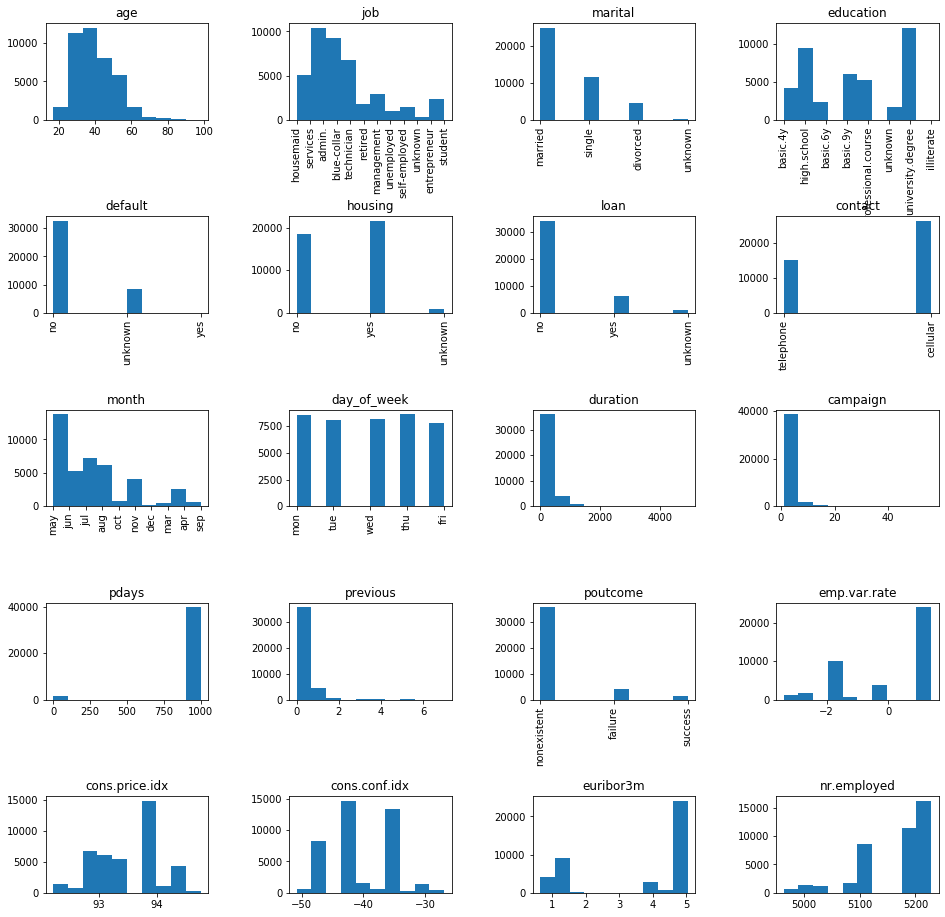

In [9]:
fig, axes = plt.subplots(5, 4, figsize = (16, 16))
fig.subplots_adjust(hspace = 1, wspace = 0.5)
axes = axes.ravel()
kwargs = {'alpha': 1}

for i, column in enumerate(term_deposit_data.columns[:-1]):
    column_series = term_deposit_data[column]
    
    axes[i].hist(column_series, **kwargs)
    axes[i].set_title(column)
    
    if(column_series.dtype == 'object'):
        axes[i].tick_params(axis='x', labelrotation=90)
plt.show()

**Findings**

* Most clients belong to the ages between 20-60. It is intuitive as these are the ages when people are looking for investment opportunities

* Highest number of clients are ones with a university degree

* 70% of the clients are new as they have **pdays** as 999 (have not been contacted previously). This can also be seen in **poutcome** (which has 70% nonexistent previous outcomes) and **previous** (70% having 0 previous contacts). Hence, these 3 variables should have higher correlation

###### Independent Variable

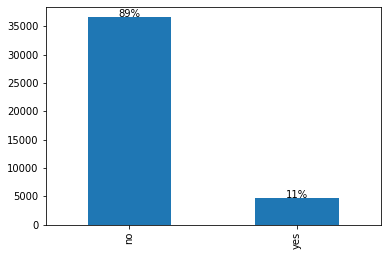

In [10]:
ax = term_deposit_data['y'].value_counts().plot.bar()

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height / term_deposit_data.shape[0]:.0%}', (x + width/2, y + height + 10), ha='center')

**Findings**

* The dataset is imbalanced, with higher number of negative samples

##### Discriptive Statistics

This includes:

* **Mean**: The arithmetic mean or average is given by the sum of all observations divided by the total number of observations

* **Std**: The standard deviation is the average deviation of values from their mean

* **Min**: Minimum value

* **25%**: First quartile, indicates value below which 25% of the values of the data fall

* **50%**: Second quartile (median), indicates value below which 50% of the values of the data fall

* **75%**: Third quartile, indicates value below which 75% of the values of the data fall

* **Max**: Maximum value

In [11]:
term_deposit_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


**Findings**

* For **age**, mean and median values are relatively close, so the distribution is closer to a normal distribution

* For **campaign**, though mean and median are close, the max value is very high, showing a possibility of outlier in the variable

##### Boxplots

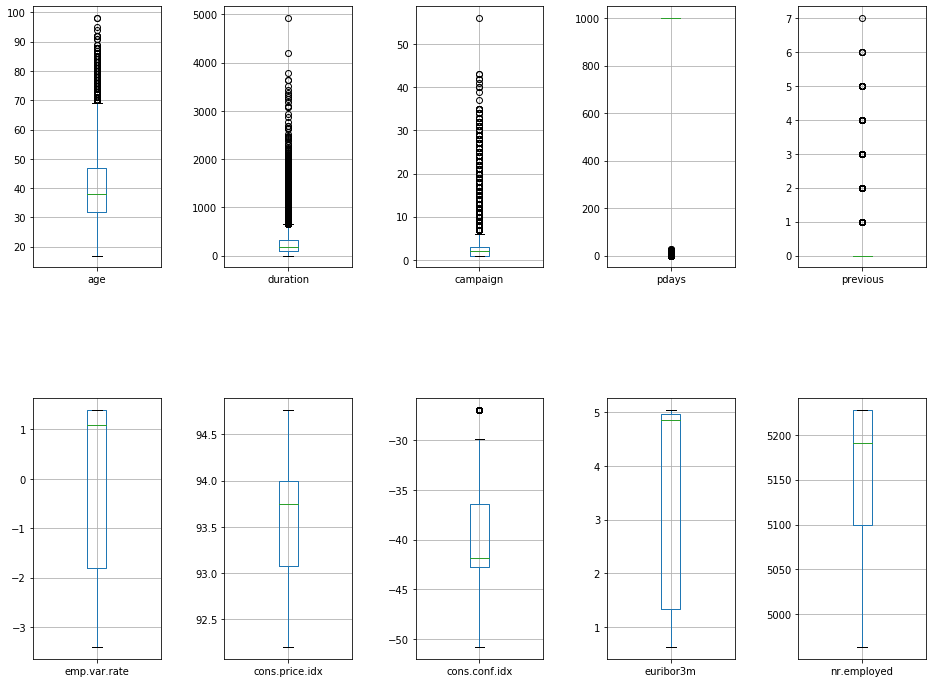

In [12]:
fig, axes = plt.subplots(2, 5, figsize = (16, 12))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
axes = axes.ravel()

i = 0
for column in term_deposit_data.columns[[is_numeric_dtype(term_deposit_data[column]) for column in term_deposit_data.columns]]:
    column_series = term_deposit_data[column]
    
    term_deposit_data[[column]].boxplot(ax=axes[i])
    i += 1
plt.show()

**Findings**

* There are outliers in **age**, **duration**, **campaign** and **cons.conf.idx**

* Outliers in **previous** can be ignored as majority of values in previous are 0 (new clients), hence cannot be used to decide the cut-off for outliers

#### Bivariate Analysis

Bivariate analysis involves the analysis of two variables for the purpose of determining the empirical relationship between them.

##### Correlation Plot

In this section, we will compute pair-wise correlation between features. The correlation coefficients considered are as follows:

* **Pearson Correlation:** It shows the co-movement of two variables and is applicable when both variables are numerical

* **Correlation Ratio:** It defines, given a continuous number, how well can the category for that number be found and is applicable when one variable is numerical and the other is categorical

* **Theil's U:** The Uncertainty Coefficient, is based on the conditional entropy between x and y, and defines how many and how frequenctly occuring states does y have for a given x. It is applicable when both variables are categorical

In [13]:
correlation_df = compute_correlation(term_deposit_data)

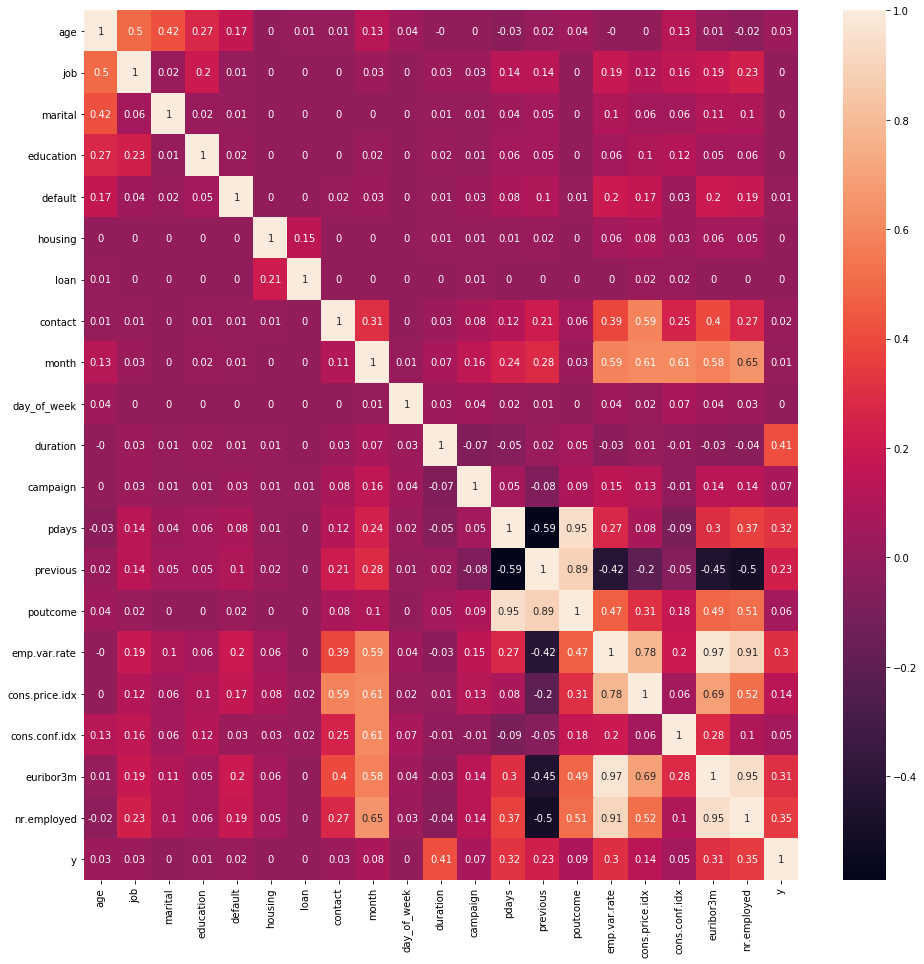

In [14]:
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(correlation_df, annot=True)
plt.show()

**Findings**

* **poutcome** has a high correlation with **pdays** and **previous**

* **nr.employed** has a high correlation with **euribor3m**

##### Data Distribution

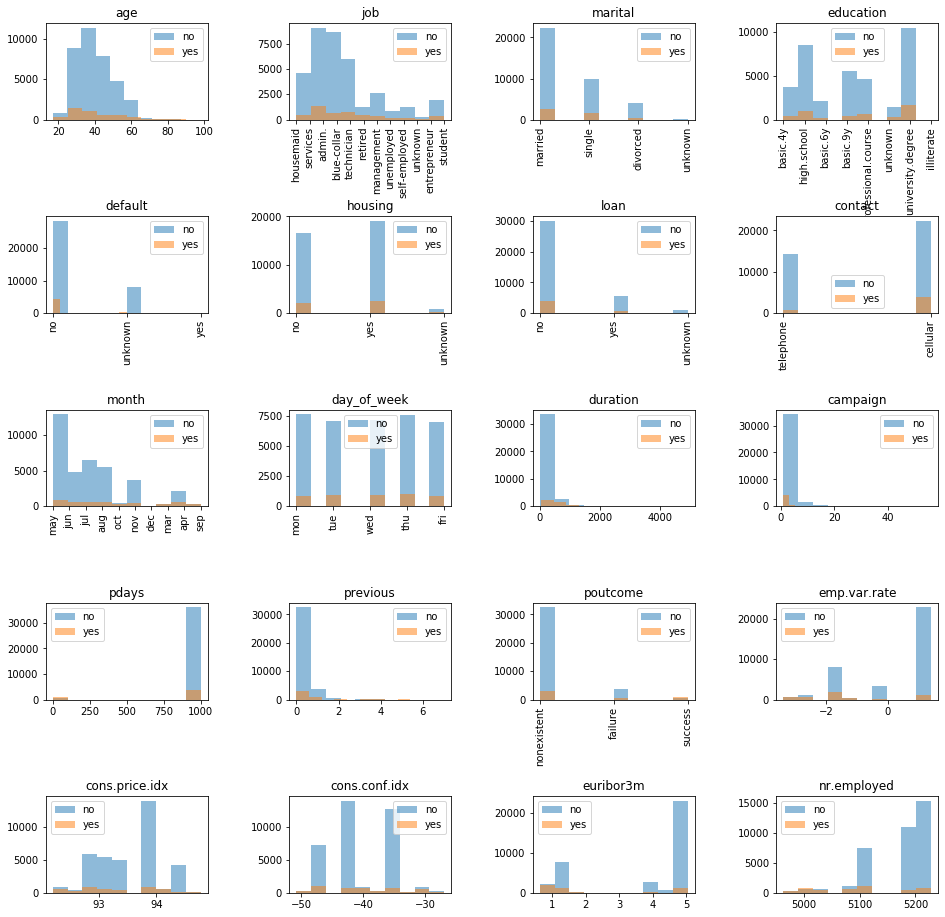

In [15]:
fig, axes = plt.subplots(5, 4, figsize = (16, 16))
fig.subplots_adjust(hspace = 1, wspace = 0.5)
axes = axes.ravel()
kwargs = {'alpha': 0.5}

for i, column in enumerate(term_deposit_data.columns[:-1]):
    column_series = term_deposit_data[column]
    sample_class = term_deposit_data['y']
    
    axes[i].hist(column_series[sample_class == 'no'], **kwargs, label='no')
    axes[i].hist(column_series[sample_class == 'yes'], **kwargs, label='yes')
    axes[i].legend()
    axes[i].set_title(column)
    
    if(column_series.dtype == 'object'):
        axes[i].tick_params(axis='x', labelrotation=90)
plt.show()

**Findings**

* Though there is an imbalance in the number of negative and positive samples, the distribution within each group is similar

##### Boxplots

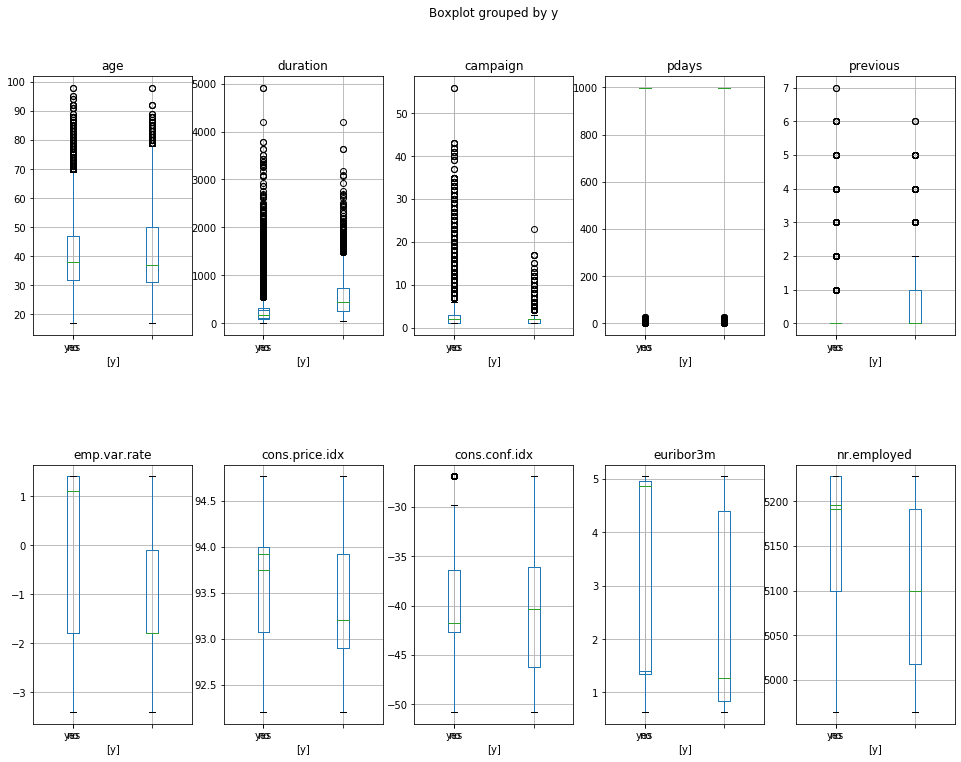

In [16]:
fig, axes = plt.subplots(2, 5, figsize = (16, 12))
fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
axes = axes.ravel()

i = 0
for column in term_deposit_data.columns[[is_numeric_dtype(term_deposit_data[column]) for column in term_deposit_data.columns]]:
    column_series = term_deposit_data[column]
    sample_class = term_deposit_data['y']
    
    term_deposit_data[[column]].boxplot(ax=axes[i])
    term_deposit_data[[column, 'y']].boxplot(by='y', ax=axes[i])
    i += 1
plt.show()

### Data Preprocessing

#### Feature Removal

We are removing **duration** as a feature as it would not be available when the final model is deployed.

In [17]:
term_deposit_data.drop(columns=['duration'], inplace=True)

#### Train-Test Split

We will split the dataset into:

* **Train Set:** This set will be used to train the model - 80%

* **Test Set:** This is the held-out set which will be used to get the generalization error of the model (to simulate performance on unseen data post deployment) - 20%

In [18]:
train_set, test_set = train_test_split(term_deposit_data, test_size = 0.2, random_state = 42)

#### Missing Value Treatment

As mentioned earlier, all missing values in our dataset are present in the categorical column. Hence, we will be treating the missing values by replacing them using the **mode** of the column.

In [19]:
train_set, test_set = missing_value_mode_treatment(train_set, test_set)

#### Outlier Treatment

As we saw in the univariate and bivariate boxplots, outliers were present in  **age**, **campaign** and **cons.conf.idx**.

* For **age** and **campaign**, we will take a log transformation to remove skewness 

* For all oulier columns, we will use Inter Quartile Range to cap values > Q3 + 1.5 * IQR and < Q1 - 1.5 * IQR to Q3 and Q1 respectively

In [20]:
train_set['age'] = np.log(train_set['age'])
test_set['age'] = np.log(test_set['age'])
train_set['age'], test_set['age'] = remove_outliers_iqr(train_set['age'], test_set['age'])

In [21]:
train_set['campaign'] = np.log(train_set['campaign'])
test_set['campaign'] = np.log(test_set['campaign'])
train_set['campaign'], test_set['campaign'] = remove_outliers_iqr(train_set['campaign'], test_set['campaign'])

In [22]:
train_set['cons.conf.idx'], test_set['cons.conf.idx'] = remove_outliers_iqr(train_set['cons.conf.idx'], test_set['cons.conf.idx'])

#### Feature Scaling

We will use MinMaxScaling to get all variables in the range between 0 and 1 to prevent any one variable from dominating in any learning algorithm.

In [23]:
train_set, test_set = min_max_scaling(train_set, test_set)

#### Encoding Categorical Variables

In [24]:
list_of_categorical_columns = list(train_set.columns[train_set.dtypes == 'object'])[:-1]

##### Target Variable

In [25]:
le = LabelEncoder()

train_set['y'] = le.fit_transform(train_set['y'])
test_set['y'] = le.transform(test_set['y'])

##### Predictor Variables

In [26]:
oe = OrdinalEncoder()

train_set_label_enc = train_set.copy()
test_set_label_enc = test_set.copy()

train_set_label_enc[list_of_categorical_columns] = oe.fit_transform(train_set[list_of_categorical_columns])
test_set_label_enc[list_of_categorical_columns] = oe.transform(test_set[list_of_categorical_columns])

### Experiments

#### Experiment 1 - Logistic Regression

##### Details

In this experiment, we will run a Logistic Regression classifier using **default parameters** for the model.

##### Modeling

###### Logistic Regression 

In [27]:
# Initialize a LogisticRegression model object
logreg_model = LogisticRegression()

# Run K-Fold cross-validation to get an idea of the generalization error and stability of the model
scores = cross_validate(logreg_model, 
                         train_set_label_enc.drop(columns=['y']), 
                         train_set_label_enc['y'], 
                         cv=10, 
                         scoring=['accuracy', 'precision', 'recall', 'f1'])

In [28]:
# Fit model on all training set
logreg_model = LogisticRegression()
logreg_model.fit(train_set_label_enc.drop(columns=['y']), train_set_label_enc['y'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##### Model Evaluation

We will look at the following metrics to evaluate our model's performance:

* Accuracy: Fraction of correct predictions by the model

* Precision: Fraction of relevant instances among the retrieved instances (positive predictive value)

* **Recall:** Fraction of retrieved relevant instances among all relevant instances (sensitivity)

* F1 Score: Harmonic mean of precision and recall 

We will use **Recall** to compare our models as we would like to capitalize on all **positive opportunities** from a business point of view.

###### Training Performance

In [29]:
data = {
    'Accuracy': scores['test_accuracy'],
    'Precision': scores['test_precision'],
    'Recall': scores['test_recall'],
    'F1 Score': scores['test_f1']
}

category_labels = ['Fold ' + str(idx) for idx in range(1, len(data['Accuracy']) + 1)]

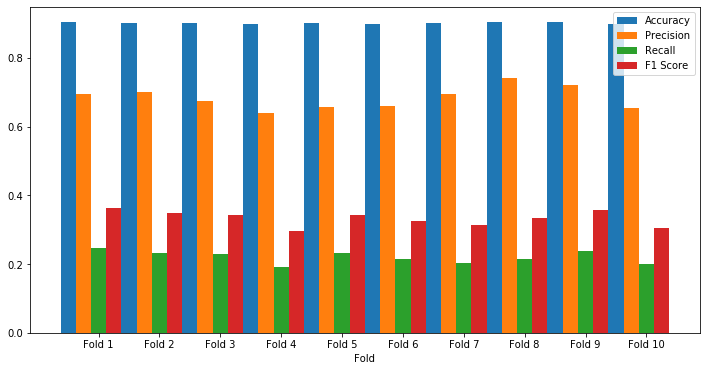

In [30]:
fig = plt.figure(figsize=(12, 6))
barWidth = 0.25

r = np.arange(1, len(data['Accuracy']) + 1)
for metric, values in data.items():
    plt.bar(r, values, width = barWidth, label = metric)
    r = [x + barWidth for x in r]
    
plt.xlabel('Fold')
plt.xticks([r + 2 * barWidth for r in range(1, len(data['Accuracy']) + 1)], category_labels)

plt.legend()
plt.show()

**Findings**

* All performance metrics are relatively stable across folds. Hence, there is low variance in the model

* The overall accuracy on the training set is very high. This is due to class imbalance as predicting everything as negative class would automatically result in high accuracy

* Recall values are low for the classifier

###### Test Performance

In [31]:
predictions = logreg_model.predict(test_set_label_enc.drop(columns='y'))

In [32]:
test_accuracy = accuracy_score(test_set_label_enc['y'], predictions)
test_precision = precision_score(test_set_label_enc['y'], predictions)
test_recall = recall_score(test_set_label_enc['y'], predictions)
test_f_score = f1_score(test_set_label_enc['y'], predictions)

In [33]:
data = {
    'Accuracy': [np.mean(scores['test_accuracy']), test_accuracy],
    'Precision': [np.mean(scores['test_precision']), test_precision],
    'Recall': [np.mean(scores['test_recall']), test_recall],
    'F1 Score': [np.mean(scores['test_f1']), test_f_score]
}

category_labels = ['Training', 'Test']

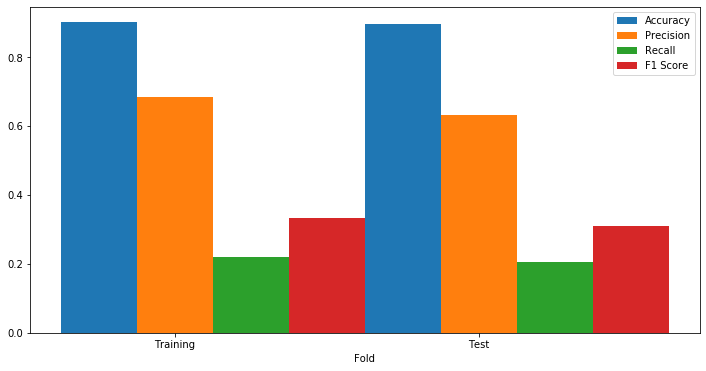

In [34]:
fig = plt.figure(figsize=(12, 6))
barWidth = 0.25

r = np.arange(1, 3)

for metric, values in data.items():
    plt.bar(r, values, width = barWidth, label = metric)
    r = [x + barWidth for x in r]
    
plt.xlabel('Fold')
plt.xticks([r + barWidth for r in range(1, len(data['Accuracy']) + 1)], category_labels)

plt.legend()
plt.show()

**Findings**

* Performance of the classifier on training and test set is almost equal. Hence, the classifier is not overfitting to the test set

* Recall values for the classifier are low, i.e., the model is not complex enough to adequately fit the dataset

##### Model Interpretation

###### Model Summary

In [35]:
model_summary = get_model_summary(logreg_model, train_set_label_enc.drop(columns=['y']), train_set_label_enc['y'])
model_summary

,Coefficients,Standard Errors,t values,Probabilities
Constant,-0.3726,0.043,-8.719,0.000
age,0.0962,0.012,8.195,0.000
job,0.0090,0.000,18.118,0.000
marital,0.0729,0.003,22.965,0.000
education,0.0368,0.001,42.694,0.000
default,-0.0338,0.182,-0.186,0.852
housing,-0.0324,0.004,-9.251,0.000
loan,0.0073,0.005,1.516,0.129
contact,-0.7986,0.005,-145.810,0.000
month,-0.0804,0.001,-79.521,0.000


**Findings**

* Apart from **default** aand **loan**, all other features are significant at 95% confidence level

* **emp.var.rate** and **cons.price.idx** are very important features

###### Variable Importance

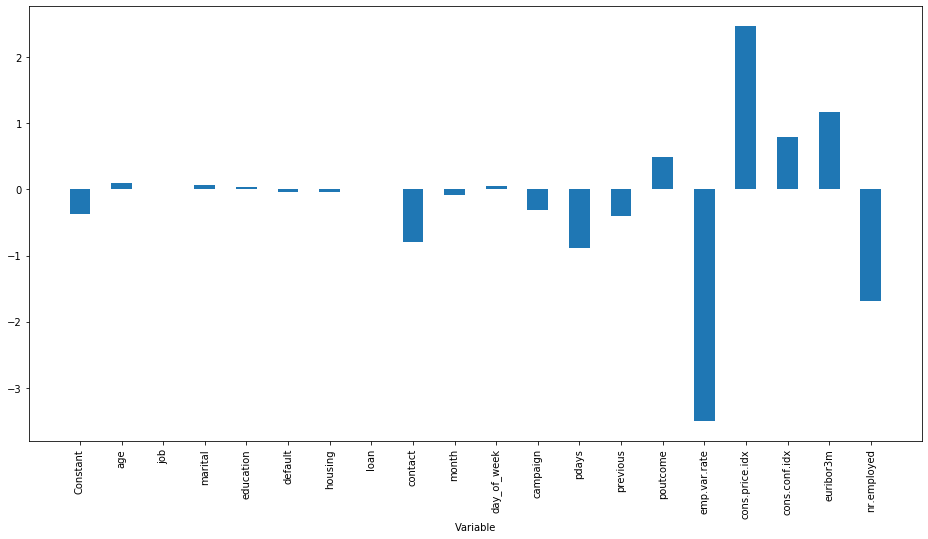

In [36]:
fig = plt.figure(figsize=(16, 8))
barWidth = 0.5

r = np.arange(1, len(model_summary) + 1)

plt.bar(r, model_summary['Coefficients'], width = barWidth, label = list(model_summary.index))

plt.xlabel('Variable')
plt.xticks([r for r in range(1, len(model_summary) + 1)], list(model_summary.index), rotation=90)

plt.show()

###### Shapley Values

It is the average of the marginal contributions across all permutations of variables and is a model agnostic approach towards model interpretibilty.

In [37]:
explainer = shap.Explainer(logreg_model, train_set_label_enc.drop(columns=['y']))

In [38]:
shap_values = explainer(test_set_label_enc.drop(columns=['y']))

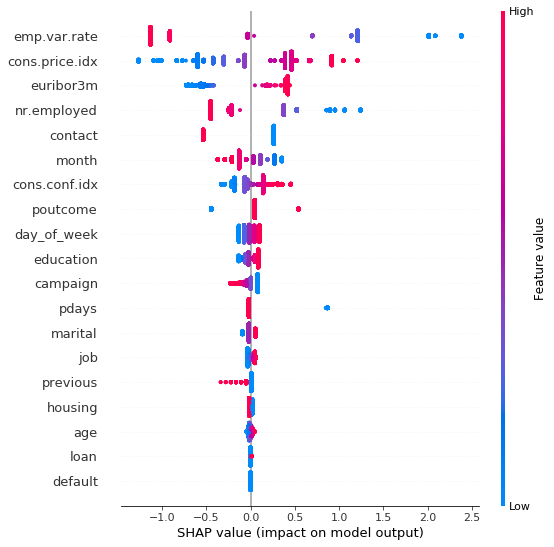

In [39]:
shap.summary_plot(shap_values, test_set_label_enc.drop(columns=['y']))

**Findings**

* ADDITIONAL ATTRIBUTES like **emp.var.rate** and **cons.price.idx** have a higher importance in predicting classes.

#### Experiment 2 - Logistic Regression with Hyper-parameter Tuning

##### Details

In this experiment, we will run a Logistic Regression classifier with optimal hyper-parameters based on parameter tuning using grid search

##### Modeling

###### Logistic Regression 

In [40]:
# Define LogisticRegression model object, hyper-parameter grid and run GridSearchCV
logreg_model = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']

penalty = ['l1', 'l2']

c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver = solvers, penalty = penalty, C = c_values)

grid_search = GridSearchCV(estimator=logreg_model, param_grid=grid, n_jobs=1, scoring='recall')
grid_result = grid_search.fit(train_set_label_enc.drop(columns=['y']), train_set_label_enc['y'])

In [41]:
# Output best parameters
grid_result.best_params_

{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}

In [42]:
# Run LogisticRegression model with optimal hyper-parameters
logreg_model = LogisticRegression(C=100, penalty='l2', solver='liblinear')

In [43]:
scores = cross_validate(logreg_model, 
                         train_set_label_enc.drop(columns=['y']), 
                         train_set_label_enc['y'], 
                         cv=10, 
                         scoring=['accuracy', 'precision', 'recall', 'f1'])

In [44]:
logreg_model = LogisticRegression(C=100, penalty='l2', solver='liblinear')
logreg_model.fit(train_set_label_enc.drop(columns=['y']), train_set_label_enc['y'])

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

##### Model Evaluation

We will look at the following metrics to evaluate our model's performance:

* Accuracy: Fraction of correct predictions by the model

* Precision: Fraction of relevant instances among the retrieved instances (positive predictive value)

* **Recall:** Fraction of retrieved relevant instances among all relevant instances (sensitivity)

* F1 Score: Harmonic mean of precision and recall 

We will use **Recall** to compare our models as we would like to capitalize on all **positive opportunities** from a business point of view.

###### Training Performance

In [45]:
data = {
    'Accuracy': scores['test_accuracy'],
    'Precision': scores['test_precision'],
    'Recall': scores['test_recall'],
    'F1 Score': scores['test_f1']
}

category_labels = ['Fold ' + str(idx) for idx in range(1, len(data['Accuracy']) + 1)]

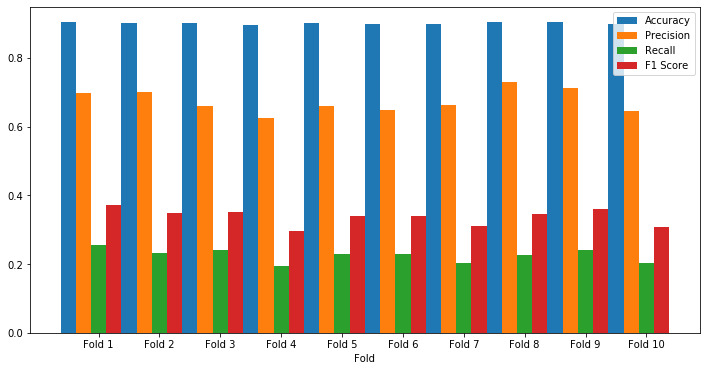

In [46]:
fig = plt.figure(figsize=(12, 6))
barWidth = 0.25

r = np.arange(1, len(data['Accuracy']) + 1)
for metric, values in data.items():
    plt.bar(r, values, width = barWidth, label = metric)
    r = [x + barWidth for x in r]
    
plt.xlabel('Fold')
plt.xticks([r + 2 * barWidth for r in range(1, len(data['Accuracy']) + 1)], category_labels)

plt.legend()
plt.show()

**Findings**

* The model is relatively stable across folds

* The overall accuracy on the training set is very high. This is due to class imbalance as predicting everything as negative class would automatically result in high accuracy

* Recall values are low for the classifier

###### Test Performance

In [47]:
predictions = logreg_model.predict(test_set_label_enc.drop(columns='y'))

In [48]:
test_accuracy = accuracy_score(test_set_label_enc['y'], predictions)
test_precision = precision_score(test_set_label_enc['y'], predictions)
test_recall = recall_score(test_set_label_enc['y'], predictions)
test_f_score = f1_score(test_set_label_enc['y'], predictions)

In [49]:
data = {
    'Accuracy': [np.mean(scores['test_accuracy']), test_accuracy],
    'Precision': [np.mean(scores['test_precision']), test_precision],
    'Recall': [np.mean(scores['test_recall']), test_recall],
    'F1 Score': [np.mean(scores['test_f1']), test_f_score]
}

category_labels = ['Training', 'Test']

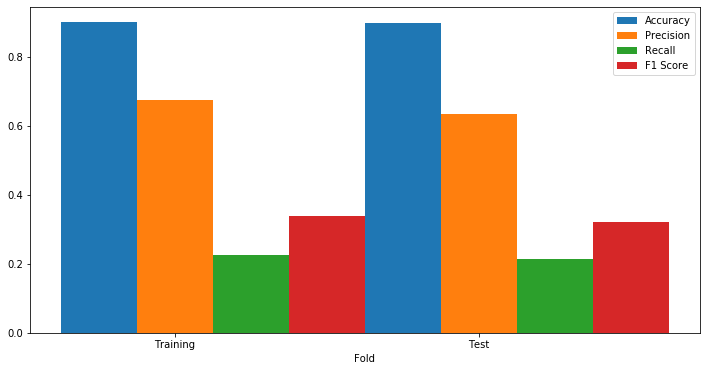

In [50]:
fig = plt.figure(figsize=(12, 6))
barWidth = 0.25

r = np.arange(1, 3)

for metric, values in data.items():
    plt.bar(r, values, width = barWidth, label = metric)
    r = [x + barWidth for x in r]
    
plt.xlabel('Fold')
plt.xticks([r + barWidth for r in range(1, len(data['Accuracy']) + 1)], category_labels)

plt.legend()
plt.show()

**Findings**

* Performance of the classifier on training and test set is almost equal. Hence, the classifier is not overfitting to the test set

* Recall values for the classifier are low

##### Model Interpretation

###### Model Summary

In [51]:
model_summary = get_model_summary(logreg_model, train_set_label_enc.drop(columns=['y']), train_set_label_enc['y'])
model_summary

,Coefficients,Standard Errors,t values,Probabilities
Constant,0.5464,0.043,12.783,0.000
age,-0.0476,0.012,-4.050,0.000
job,0.0076,0.000,15.295,0.000
marital,0.0481,0.003,15.159,0.000
education,0.0315,0.001,36.435,0.000
default,-0.2026,0.182,-1.114,0.265
housing,-0.0300,0.004,-8.571,0.000
loan,-0.0040,0.005,-0.828,0.407
contact,-0.8311,0.005,-151.680,0.000
month,-0.0928,0.001,-91.786,0.000


**Findings**

* Apart from **default** aand **loan**, all other features are significant at 95% confidence level

* **emp.var.rate**, **eruibor3m**, **nr.employed** and **cons.price.idx** are very important features

###### Variable Importance

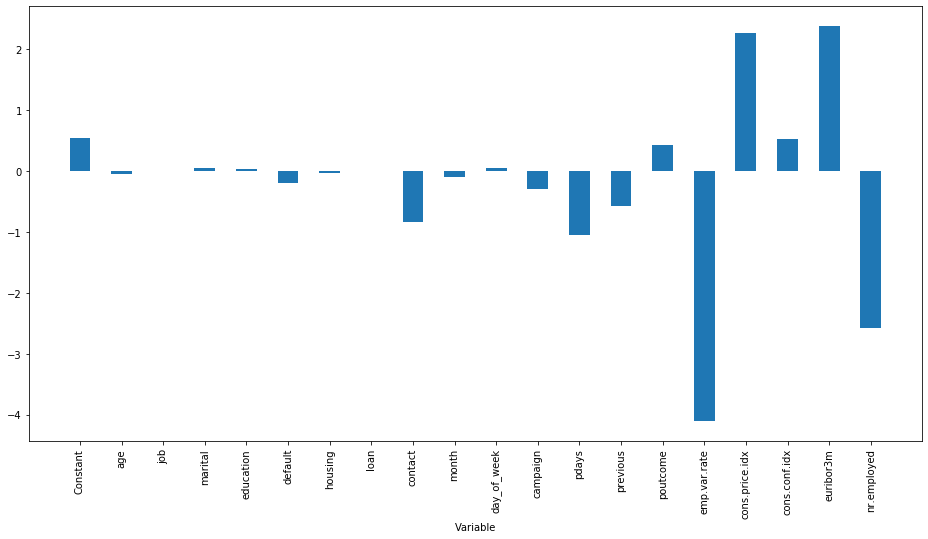

In [52]:
fig = plt.figure(figsize=(16, 8))
barWidth = 0.5

r = np.arange(1, len(model_summary) + 1)

plt.bar(r, model_summary['Coefficients'], width = barWidth, label = model_summary.index)

plt.xlabel('Variable')
plt.xticks([r for r in range(1, len(model_summary) + 1)], model_summary.index, rotation=90)

plt.show()

###### Shapley Values

It is the average of the marginal contributions across all permutations of variables and is a model agnostic approach towards model interpretibilty.

In [53]:
explainer = shap.Explainer(logreg_model, train_set_label_enc.drop(columns=['y']))

In [54]:
shap_values = explainer(test_set_label_enc.drop(columns=['y']))

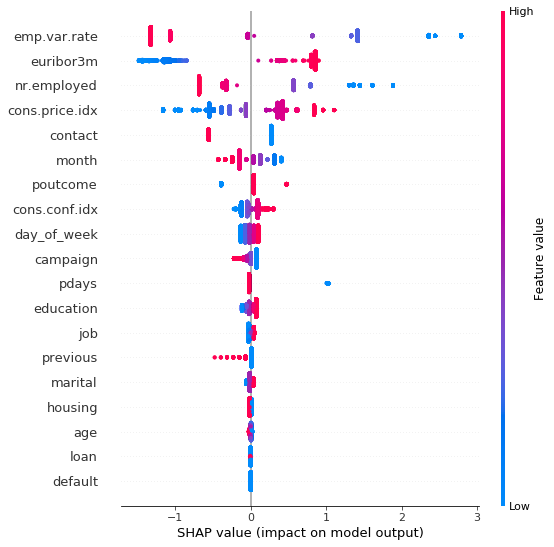

In [55]:
shap.summary_plot(shap_values, test_set_label_enc.drop(columns=['y']))

**Findings**

* **emp.var.rate**, **eruibor3m**, **nr.employed** and **cons.price.idx** are very important features

#### Experiment 3 - Logistic Regression with Feature Selection

##### Details

In this experiment, we will run a Logistic Regression classifier after removing variables having very high correlation.

##### Feature Selection

We are dropping the following features:

* **poutcome** as it is highly correlated with both **pdays** and **previous**

* **euribor3m** and **nr.employed** as they are highly correlated to each other and to **emp.var.rate**

* **default** and **loan** as they have come up as unimportant variables in the previous experiments

In [56]:
train_set_label_enc_filtered = train_set_label_enc.drop(columns=['poutcome', 'euribor3m', 'nr.employed', 'default', 'loan'])
test_set_label_enc_filtered = test_set_label_enc.drop(columns=['poutcome', 'euribor3m', 'nr.employed', 'default', 'loan'])

##### Modeling

###### Logistic Regression 

In [57]:
logreg_model = LogisticRegression()

scores = cross_validate(logreg_model, 
                         train_set_label_enc_filtered.drop(columns=['y']), 
                         train_set_label_enc_filtered['y'], 
                         cv=10, 
                         scoring=['accuracy', 'precision', 'recall', 'f1'])

In [58]:
logreg_model = LogisticRegression()
logreg_model.fit(train_set_label_enc_filtered.drop(columns=['y']), train_set_label_enc_filtered['y'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##### Model Evaluation

We will look at the following metrics to evaluate our model's performance:

* Accuracy: Fraction of correct predictions by the model

* Precision: Fraction of relevant instances among the retrieved instances (positive predictive value)

* **Recall:** Fraction of retrieved relevant instances among all relevant instances (sensitivity)

* F1 Score: Harmonic mean of precision and recall 

We will use **Recall** to compare our models as we would like to capitalize on all **positive opportunities** from a business point of view.

###### Training Performance

In [59]:
data = {
    'Accuracy': scores['test_accuracy'],
    'Precision': scores['test_precision'],
    'Recall': scores['test_recall'],
    'F1 Score': scores['test_f1']
}

category_labels = ['Fold ' + str(idx) for idx in range(1, len(data['Accuracy']) + 1)]

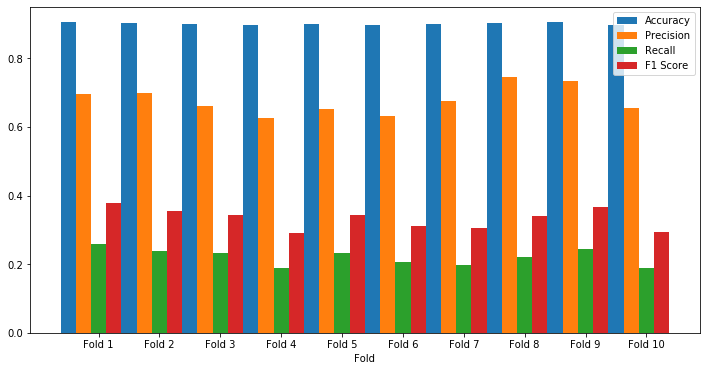

In [60]:
fig = plt.figure(figsize=(12, 6))
barWidth = 0.25

r = np.arange(1, len(data['Accuracy']) + 1)
for metric, values in data.items():
    plt.bar(r, values, width = barWidth, label = metric)
    r = [x + barWidth for x in r]
    
plt.xlabel('Fold')
plt.xticks([r + 2 * barWidth for r in range(1, len(data['Accuracy']) + 1)], category_labels)

plt.legend()
plt.show()

**Findings**

* The overall accuracy on the training set is very high. This is due to class imbalance as predicting everything as negative class would automatically result in high accuracy

* Recall values are low for the classifier

###### Test Performance

In [61]:
predictions = logreg_model.predict(test_set_label_enc_filtered.drop(columns='y'))

In [62]:
test_accuracy = accuracy_score(test_set_label_enc['y'], predictions)
test_precision = precision_score(test_set_label_enc['y'], predictions)
test_recall = recall_score(test_set_label_enc['y'], predictions)
test_f_score = f1_score(test_set_label_enc['y'], predictions)

In [63]:
data = {
    'Accuracy': [np.mean(scores['test_accuracy']), test_accuracy],
    'Precision': [np.mean(scores['test_precision']), test_precision],
    'Recall': [np.mean(scores['test_recall']), test_recall],
    'F1 Score': [np.mean(scores['test_f1']), test_f_score]
}

category_labels = ['Training', 'Test']

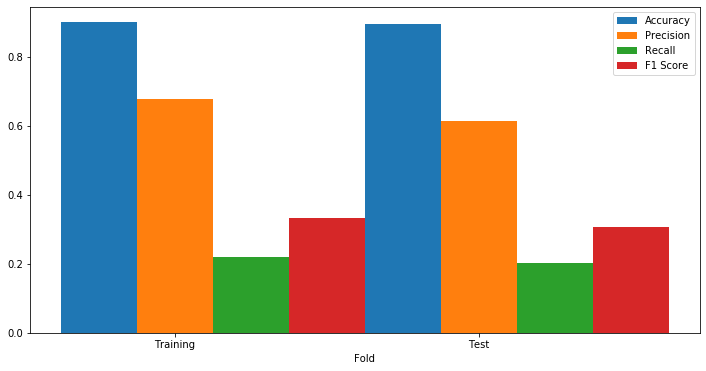

In [64]:
fig = plt.figure(figsize=(12, 6))
barWidth = 0.25

r = np.arange(1, 3)

for metric, values in data.items():
    plt.bar(r, values, width = barWidth, label = metric)
    r = [x + barWidth for x in r]
    
plt.xlabel('Fold')
plt.xticks([r + barWidth for r in range(1, len(data['Accuracy']) + 1)], category_labels)

plt.legend()
plt.show()

**Findings**

* Performance of the classifier on training and test set is almost equal. Hence, the classifier is not overfitting to the test set

* Recall values for the classifier are low

##### Model Interpretation

###### Model Summary

In [65]:
model_summary = get_model_summary(logreg_model, train_set_label_enc_filtered.drop(columns=['y']), train_set_label_enc_filtered['y'])
model_summary

,Coefficients,Standard Errors,t values,Probabilities
Constant,-0.1665,0.018,-9.385,0.0
age,0.1436,0.012,12.212,0.0
job,0.0089,0.000,18.051,0.0
marital,0.0886,0.003,27.868,0.0
education,0.0387,0.001,44.859,0.0
housing,-0.0182,0.004,-5.193,0.0
contact,-0.9068,0.005,-174.671,0.0
month,-0.0622,0.001,-74.723,0.0
day_of_week,0.0602,0.001,48.173,0.0
campaign,-0.3329,0.007,-46.945,0.0


**Findings**

* All features are significant at 95% confidence level

* **emp.var.rate** and **cons.price.idx** are very important features

###### Variable Importance

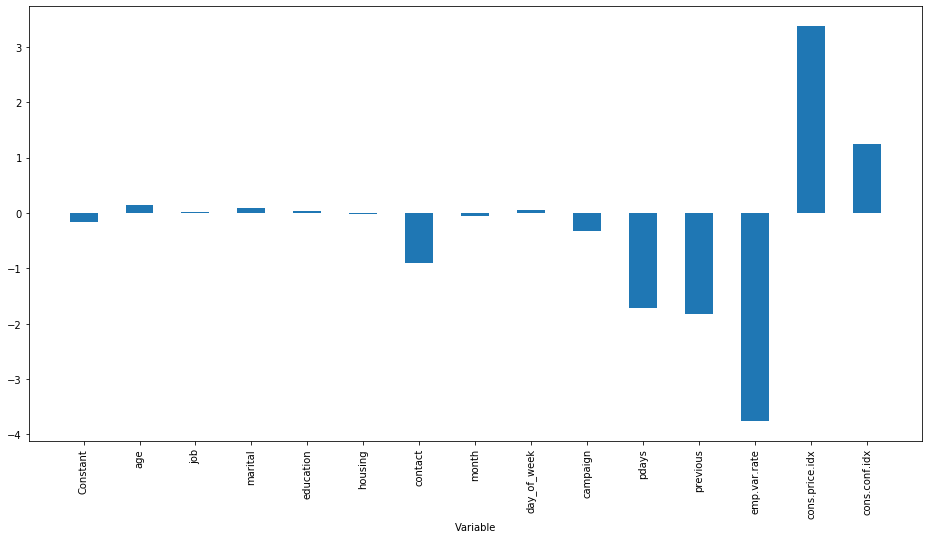

In [66]:
fig = plt.figure(figsize=(16, 8))
barWidth = 0.5

r = np.arange(1, len(model_summary) + 1)

plt.bar(r, model_summary['Coefficients'], width = barWidth, label = model_summary.index)

plt.xlabel('Variable')
plt.xticks([r for r in range(1, len(model_summary) + 1)], model_summary.index, rotation=90)

plt.show()

###### Shapley Values

It is the average of the marginal contributions across all permutations of variables and is a model agnostic approach towards model interpretibilty.

In [67]:
explainer = shap.Explainer(logreg_model, train_set_label_enc_filtered.drop(columns=['y']))

In [68]:
shap_values = explainer(test_set_label_enc_filtered.drop(columns=['y']))

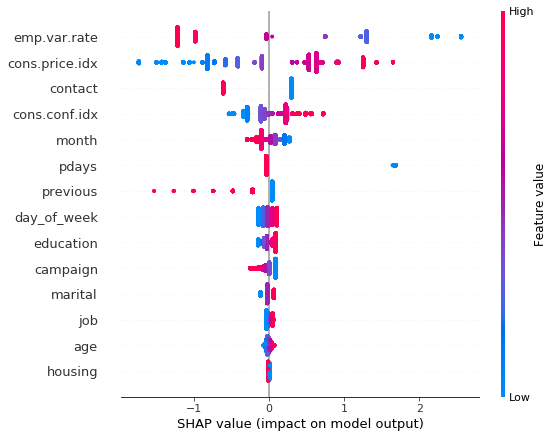

In [69]:
shap.summary_plot(shap_values, test_set_label_enc_filtered.drop(columns=['y']))

**Findings**

* **emp.var.rate** and **cons.price.idx** are very important features

#### Experiment 4 -Decision Tree Classifier

##### Details

In this experiment, we will run a Decision Tree classifier with default parameters.

##### Modeling

###### Logistic Regression 

In [70]:
dtree_model = DecisionTreeClassifier()

scores = cross_validate(dtree_model, 
                         train_set_label_enc.drop(columns=['y']), 
                         train_set_label_enc['y'], 
                         cv=10, 
                         scoring=['accuracy', 'precision', 'recall', 'f1'])

In [71]:
dtree_model = DecisionTreeClassifier()
dtree_model.fit(train_set_label_enc.drop(columns=['y']), train_set_label_enc['y'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

##### Model Evaluation

We will look at the following metrics to evaluate our model's performance:

* Accuracy: Fraction of correct predictions by the model

* Precision: Fraction of relevant instances among the retrieved instances (positive predictive value)

* **Recall:** Fraction of retrieved relevant instances among all relevant instances (sensitivity)

* F1 Score: Harmonic mean of precision and recall 

We will use **Recall** to compare our models as we would like to capitalize on all **positive opportunities** from a business point of view.

###### Training Performance

In [72]:
data = {
    'Accuracy': scores['test_accuracy'],
    'Precision': scores['test_precision'],
    'Recall': scores['test_recall'],
    'F1 Score': scores['test_f1']
}

category_labels = ['Fold ' + str(idx) for idx in range(1, len(data['Accuracy']) + 1)]

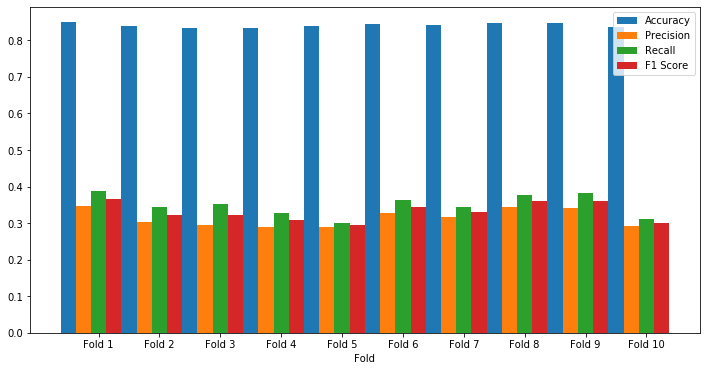

In [73]:
fig = plt.figure(figsize=(12, 6))
barWidth = 0.25

r = np.arange(1, len(data['Accuracy']) + 1)
for metric, values in data.items():
    plt.bar(r, values, width = barWidth, label = metric)
    r = [x + barWidth for x in r]
    
plt.xlabel('Fold')
plt.xticks([r + 2 * barWidth for r in range(1, len(data['Accuracy']) + 1)], category_labels)

plt.legend()
plt.show()

**Findings**

* We see a **significant** improvement in recall over previous experiments

* The overall accuracy on the training set is very high. This is due to class imbalance as predicting everything as negative class would automatically result in high accuracy

###### Test Performance

In [74]:
predictions = dtree_model.predict(test_set_label_enc.drop(columns='y'))

In [75]:
test_accuracy = accuracy_score(test_set_label_enc['y'], predictions)
test_precision = precision_score(test_set_label_enc['y'], predictions)
test_recall = recall_score(test_set_label_enc['y'], predictions)
test_f_score = f1_score(test_set_label_enc['y'], predictions)

In [76]:
data = {
    'Accuracy': [np.mean(scores['test_accuracy']), test_accuracy],
    'Precision': [np.mean(scores['test_precision']), test_precision],
    'Recall': [np.mean(scores['test_recall']), test_recall],
    'F1 Score': [np.mean(scores['test_f1']), test_f_score]
}

category_labels = ['Training', 'Test']

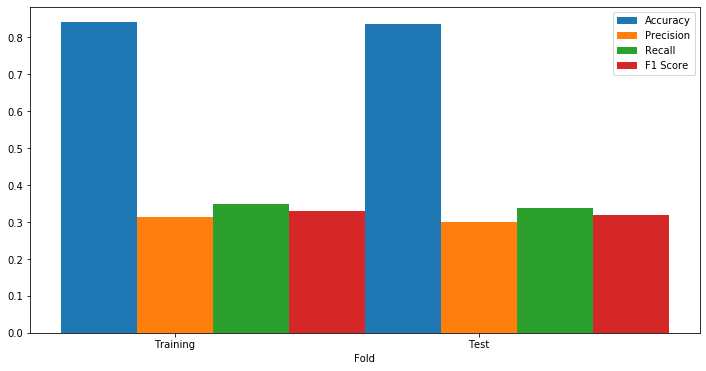

In [77]:
fig = plt.figure(figsize=(12, 6))
barWidth = 0.25

r = np.arange(1, 3)

for metric, values in data.items():
    plt.bar(r, values, width = barWidth, label = metric)
    r = [x + barWidth for x in r]
    
plt.xlabel('Fold')
plt.xticks([r + barWidth for r in range(1, len(data['Accuracy']) + 1)], category_labels)

plt.legend()
plt.show()

**Findings**

* Performance of the classifier on training and test set is almost equal. Hence, the classifier is not overfitting to the test set

* Recall values for the classifier are better than previous experiments, but are still low

##### Model Interpretation

###### Variable Importance

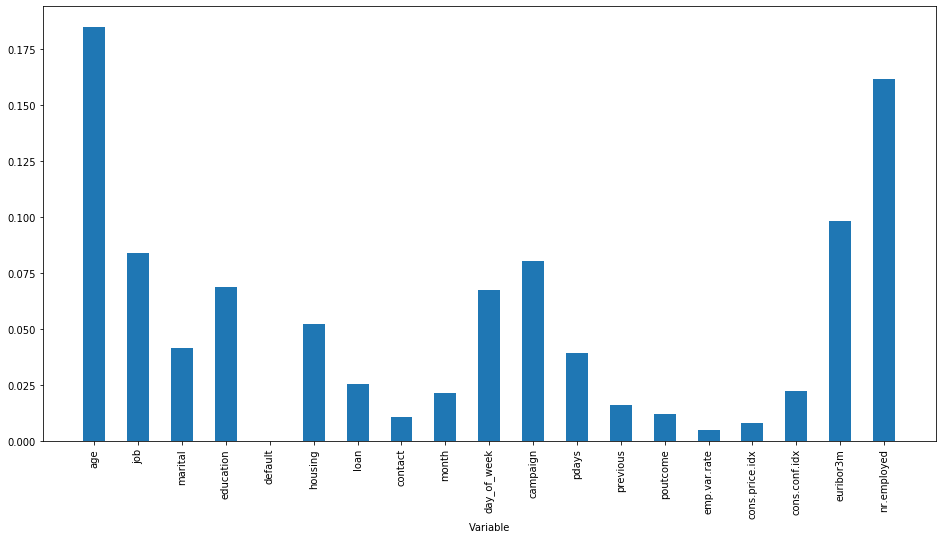

In [78]:
fig = plt.figure(figsize=(16, 8))
barWidth = 0.5

r = np.arange(1, len(dtree_model.feature_importances_) + 1)

plt.bar(r, dtree_model.feature_importances_, width = barWidth, label = train_set_label_enc.columns[:-1])

plt.xlabel('Variable')
plt.xticks([r for r in range(1, len(dtree_model.feature_importances_) + 1)], train_set_label_enc.columns[:-1], rotation=90)

plt.show()

**Findings**

* **age** and **nr.employed** are very important features

## Conclusion

* Analysis of dataset reveals

    * 70% of the clients are new as there is no data available for previous contacts for these clients, as seen in the **pdays**, **poutcome** and **previous** variables.
    
    * Highest number of clients have a university degree. Also, majority of the clients belong to the working category (between ages 20 and 60).
    
    * There is a high correlation between **poutcome**, **previous** and **pdays** as all these variables represent information from previous contact with the client. **euribor3m**, **nr.employed** and **emp.var.rate** also have very high correlation with one another.
    
    * Unknown values are present only in CLIENT DATA categorical variables
    
* **Recall** was selected as the metric to compare predictive models as improving recall would allow us to capitalize on all positive opportunities
    
* First 3 experiments with linear model (Logistic Regression) revealed

    * The model has a low variance (based on K-Fold CV) and low bias (since training and test performance are equal)
    
    * The model is not complex enough to represent the complete hypothesis space as the model has a very **low recall value (20%)**
    
    * Even with **hyper-parameter tuning** and **feature selection based on correlation**, the model performance did not improve
    
* Last experiment with a non-linear model (Decision Tree Classifier) revealed

    * The model has a low variance (based on K-Fold CV) and low bias (since training and test performance are equal)
    
    * Using a non-linear model **improved recall value (40%)** when compared against linear Logistic Regression model
    
    * **The relation between predictor and response variables is non-linear**

## Next Steps

* Feature selection based on ensemble voting using multiple feature selection techniques

* Hyper-parameter tuning Decision Tree model

* Adding more complex non-linear models (RandomForest, XGBoost, Multi-Layer Perceptron etc.)

## Appendix

### References

* [Term Deposit Definition](https://www.investopedia.com/terms/t/termdeposit.asp#:~:text=A%20term%20deposit%20is%20a,levels%20of%20required%20minimum%20deposits.)

* [Correlation for Categorical, Numeric and Mixed Data](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)

* [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall)

* [SHAP value for model interpretibility](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)